In [1]:
import pandas as pd, psycopg2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def query_database(connection, sql, *args, **kwargs):
    if connection.get_transaction_status() == 3:
        connection.reset()
    with connection.cursor() as cursor:
        cursor.execute(sql, *args, **kwargs)
        rows = cursor.fetchall()
        columns = [d[0] for d in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    return df

In [3]:
connection = psycopg2.connect('postgres://fga@localhost/fga')

In [19]:
# sql = '''
# select "action" as action, count(1) from events group by 1 order by 2 desc
# '''
# df = query_database(connection, sql)
# df

In [20]:
sql = '''
with users_ as (
    select
        "CreatedAt" as created_at,
        "UserID" as user_id,
        "DeviceOS" as client
        
    from devices

), events_ as (
    select
        "createdAt" as ts,
        "currentUser" as user_id,
        "action" as action
        
    from events
    
), quiz_events as (
    select
        ts,
        user_id
        
    from events_
    
    where action = 'START_QUIZ'
    
), n_submitted_quiz as (
    select
        created_at::date as date,
        client,
        count(distinct user_id) as n_submitted_quiz
        
    from users_ join quiz_events using (user_id)
    
    where ts >= created_at
        and ts::timestamp < created_at::timestamp + interval '1 day'
        
    group by 1, 2
        
), n_new_users as (
    select
        "CreatedAt"::date as date,
        "DeviceOS" as client,
        count(distinct "UserID") as n_new_users
        
    from devices
    
    group by 1, 2
    
), results as (
    select
        date,
        client,
        n_new_users,
        n_submitted_quiz,
        n_submitted_quiz::float / n_new_users * 100 as percent
        
    from n_new_users
        join n_submitted_quiz using (date, client)

)

select * from results
'''

df = query_database(connection, sql)
df.head()

,date,client,n_new_users,n_submitted_quiz,percent
0,2019-10-13,Android,115,4,3.478261
1,2019-10-13,iOS,105,6,5.714286
2,2019-10-14,Android,39,18,46.153846
3,2019-10-14,iOS,57,26,45.614035
4,2019-10-15,Android,9,3,33.333333


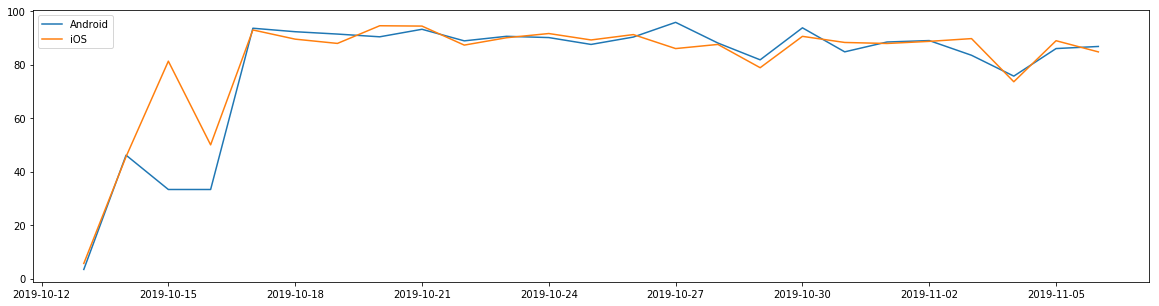

In [22]:
fig, ax = plt.subplots(figsize=(20, 5))
for client, df_ in df.groupby('client'):
    ax.plot(df_['date'], df_['percent'], label=client)
ax.legend()

In [23]:
sql = ''' select * from events limit 10 '''
df = query_database(connection, sql)
df.head()

,id,version,createdAt,updatedAt,deleted,info,warn,error,previosPage,currentPage,action,subAction,params,currentUser,currentUserProfile,userDevice,userCountry
0,00000ef7-44bf-44e9-bb16-e452a683d872,\x0000000000cd7cc1,2019-10-17 22:34:12.3162084 +00:00,2019-10-17 22:34:12.3162084 +00:00,False,True,False,False,OFFERS,OFFERS,APP_PAUSED,,0.0,35e9ef31-386d-4701-988d-c228f25df219,02674699-E2E3-4933-AB6E-CE33573FE39A,A8D3D978-2387-4EB6-B995-846FD2DC473A,us
1,0000199f-732a-4ef8-a033-908578b37086,\x0000000000dd0b91,2019-11-08 04:38:38.0990040 +00:00,2019-11-08 04:38:38.0990040 +00:00,False,True,False,False,APP_PRE_LOAD,APP_LOAD,APP_PAUSED,,0.0,52279533-0121-4553-9d66-27d50a30f457,8328B8A8-44F8-45AB-866F-6236D42E90D4,C4EBFEE1-3436-4267-939B-817BF6A75C18,us
2,000022d9-2f4e-49be-813e-6f1ad2540b68,\x0000000000dffb98,2019-11-10 23:48:48.6651948 +00:00,2019-11-10 23:48:48.6651948 +00:00,False,True,False,False,QUIZ_RESULT_DETAILS,QUIZ_RESULTS,LOADED,,0.0,e4e6681f-b80d-40a9-b7d4-219fd6cbc7cc,27CE248A-4B83-4E3D-801E-370DAE436E27,A5BDCF9F-AF87-4F18-BCB3-D1608A8BDB12,us
3,00002bd7-7ae3-4a11-b49b-2acaa7815c69,\x0000000000dfa15c,2019-11-10 20:06:11.4216982 +00:00,2019-11-10 20:06:11.4216982 +00:00,False,True,False,False,APP_PRE_LOAD,APP_LOAD,COMPETITION_CLICK,,990001.0,fc588da2-39c3-439e-8914-d91b812674f7,89669129-9582-47CA-AF91-1CABF344B2BD,A6F9EA2D-F341-4698-818E-4CC0ADF90A62,us
4,00002cc2-7b83-43f3-9222-1a6cb25e3a95,\x0000000000db8ffe,2019-11-06 14:24:05.8718009 +00:00,2019-11-06 14:24:05.8718009 +00:00,False,True,False,False,QUIZ_GAME_DETAILS,QUIZ_GAME_DETAILS,APP_PAUSED,,0.0,d83fe34b-6b96-4790-b10d-33536e7f6584,CC443E7E-461D-4F89-BD9F-340728133013,88F2C9BE-BA8C-48E2-97CF-807A3E3622D0,us


In [24]:
sql = ''' select * from devices limit 10 '''
df = query_database(connection, sql)
df.head()

,Id,DeviceId,DeviceName,DeviceMan,DeviceOS,DeviceOSVer,AppVersion,UserID,UserProfileID,Version,CreatedAt,UpdatedAt,Deleted,DeviceSerial,DeviceIsVirtual,DeviceUDID,OtherID1,OtherID1Previous,SimDeviceId
0,5FFC68A4-B539-4652-85FD-C062F96B2F6C,6daac5cb0706b620,Gemini Pro,Ulefone,Android,7.1.1,WEB_BROWSERx,D038FF0A-7930-44D9-9B90-3B1D4B01B653,EDFFC601-0C87-40B4-9AB0-A55B4D654AAE,\x0000000000751ec2,2018-01-14 08:31:54.6055341 +00:00,2019-01-18 12:37:42.0871351 +00:00,False,None,False,unknown,b65b676bc8d3e1e383704e97e7d812d1,b65b676bc8d3e1e383704e97e7d812d1,unknown
1,07E923A7-2F91-4F27-931B-675162C31881,a907b79f3bc2d8b8,Nexus 5X,LGE,Android,8.1.0,0.9.1,3876B0EB-D7AB-4FF0-B2C6-3071EE7E3185,35842A1B-C1C8-4A6D-8077-8D5AB72D84F3,\x0000000000005431,2018-01-14 08:42:20.3325653 +00:00,2018-01-14 08:42:20.3325653 +00:00,False,None,False,None,None,None,None
2,E44CF7F4-FF2C-4AE3-BCAA-FF0ECC51AB74,000000000000000011,SM-G920F,samsung,Android,7.0,0.9.1,431B96BA-33C0-4CE0-AE52-83426516F4BB,F03CE291-1AD2-42EE-9070-C38BB2A91C03,\x0000000000714ee9,2018-01-14 12:27:31.8089144 +00:00,2018-08-03 17:16:26.7197938 +00:00,False,None,False,None,None,None,None
3,B81614A3-1102-4DA8-B57F-341BBCFE7CE3,42ac18025c7c4b85,A0001,OnePlus,Android,6.0.1,0.9.1,A7E162D3-6983-45CB-898D-A97CF86D4053,CB492FB3-168F-47BD-BC7A-1A4DE6366C96,\x0000000000005676,2018-01-14 12:30:47.5445520 +00:00,2018-01-14 12:30:47.5445520 +00:00,False,None,False,None,None,None,None
4,1F81EEDF-D6FA-400D-B280-65498E2D1E9F,1bb88d070b2f3e90,WAS-LX1A,HUAWEI,Android,7.0,0.9.1,70BC4E78-C564-450D-BD2B-F4FC27B4DE06,CE563208-2F79-48E4-9DED-F158BC85FB51,\x00000000000056a6,2018-01-14 12:48:12.7965903 +00:00,2018-01-14 12:48:12.7965903 +00:00,False,None,False,None,None,None,None


In [25]:
sql = ''' select * from users limit 10 '''
df = query_database(connection, sql)
df.head()

,Id,ManagerName,Balance,IsGuest,IsActive,IsBot,UserBadge,ManagerLevel,Version,CreatedAt,...,LastWeekRank,LastMonthFanCoins,LastMonthRank,HasSeenTutorial,MonthToDateFanCoinsUsed,LastMonthFanCoinsUsed,FreeVideoAdTicketsGained,LastFreeVideoAdTicketsPermissionsResetDate,QuizesPlayedToday,LastQuizPermissionsResetDate
0,C8C12E5E-E844-4AFE-B7C3-6FFAF45B2F03,Guest B88833042,1000000,False,True,True,4,1,\x0000000000a66064,2018-01-14 08:13:42.2082798 +00:00,...,0,0,0,False,0,0,-1,0001-01-01 00:00:00.0000000 +00:00,-1,0001-01-01 00:00:00.0000000 +00:00
1,AE70972E-E33E-4111-8331-1BC313687976,Guest B88825298,1000000,False,True,True,10,1,\x0000000000a653c8,2018-01-14 08:13:42.2707801 +00:00,...,0,0,0,False,0,0,-1,0001-01-01 00:00:00.0000000 +00:00,-1,0001-01-01 00:00:00.0000000 +00:00
2,DC35F831-9F6F-4B9E-8E85-34B4AB4AF766,Guest B88847293,1000000,False,True,True,13,1,\x0000000000a669df,2018-01-14 08:13:42.2864394 +00:00,...,0,0,0,False,0,0,-1,0001-01-01 00:00:00.0000000 +00:00,-1,0001-01-01 00:00:00.0000000 +00:00
3,5EDF2037-53DC-4F32-85E2-D2A50D3D214D,Guest B88889152,1000000,False,True,True,6,1,\x0000000000a62e44,2018-01-14 08:13:42.2864394 +00:00,...,0,0,0,False,0,0,-1,0001-01-01 00:00:00.0000000 +00:00,-1,0001-01-01 00:00:00.0000000 +00:00
4,C72A4B2B-02B8-4314-8C64-E749836D497C,Guest B88894313,1000000,False,True,True,0,1,\x0000000000a65fa2,2018-01-14 08:13:42.2864394 +00:00,...,0,0,0,False,0,0,-1,0001-01-01 00:00:00.0000000 +00:00,-1,0001-01-01 00:00:00.0000000 +00:00
